In [53]:
import numpy as np
import networkx as nx
import random
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np


class NodeLabel:
    def __init__(self, start, end, copy_number):
        self.start = start
        self.end = end
        self.copy_number = copy_number
    
    def get_event(self):
        return (self.start, self.end)
    
    def __str__(self):
        return "(" + str(self.start) + "," + str(self.end) + ") " + str(int(self.copy_number))
        return "(" + str(self.start) + "," + str(self.end) + ") CN:" + str(self.copy_number) + "\n"
    
    def overlaps(self, node_label):
        return (self.start >= node_label.start and self.start < node_label.end)\
                or (self.end > node_label.start and self.end < node_label.end)
            
class CNSampler:
    #should not contain CN=2
    def __init__(self, CN_to_weight, CN_to_sd):
        self.CN_to_weight = CN_to_weight
        sum_ = sum(list(CN_to_weight.values()))
        for key in self.CN_to_weight.keys():
            self.CN_to_weight[key] = self.CN_to_weight[key] / sum_
        self.CN_to_sd = CN_to_sd
        self.NEUTRAL_CN = 2 
        
    def sample_CN(self):
        return np.random.choice(list(self.CN_to_weight.keys()), 1, p = list(self.CN_to_weight.values()))[0]
    
    def sample_corrected_count(self, count): 
        cc = count + np.random.normal(0, self.CN_to_sd[int(count)], 1)
        while cc < 0:
            cc = count + np.random.normal(0, self.CN_to_sd[int(count)], 1)
        return cc

In [54]:
class TreeGenerator:
    def __init__(self, cn_sampler):
        self.cn_sampler = cn_sampler
        
    def generate_random_tree(self, no_loci, tree_size):
        tree_nodes_list = self.__sample_node_labels(tree_size, no_loci)
        tree = self.__random_tree(tree_nodes_list)
        while not self.__check_valid(tree):
            tree_nodes_list = self.__sample_node_labels(tree_size, no_loci)
            tree = self.__random_tree(tree_nodes_list)
        return tree
    
    def __sample_node_label(self, labels):
        norming_constant = 0
        for z in labels:
            norming_constant += np.exp(0.1 * (z[0] - z[1]))
        while True:
            label = random.sample(labels, 1)[0]
            if np.random.uniform() < np.exp(0.1 * (label[0] - label[1])) / norming_constant:
                return label

    def __sample_node_labels(self, tree_size, no_loci):
        candidates = list(filter(lambda x: x[0] < x[1], [(a, b) for a in range(0, no_loci) for b in range(0, no_loci)]))
        result = list()
        for n in range(0, tree_size):
            label = self.__sample_node_label(candidates)
            candidates.remove(label)
            result.append(NodeLabel(label[0], label[1], self.cn_sampler.sample_CN()))
        result.insert(0, NodeLabel(0, 0, self.cn_sampler.NEUTRAL_CN))
        return result
    
    def __random_tree(self, nodes):
        tree = nx.DiGraph()
        bit_map = np.zeros(len(nodes))
        bit_map[0] = 1
        visited = 1
        current_node = 0
        while len(nodes) > visited:
            new_node = random.sample(range(0, len(nodes)), 1)[0]
            if bit_map[new_node] == 0.0:
                bit_map[new_node] = 1.0
                tree.add_edge(nodes[current_node], nodes[new_node])
                visited += 1
            current_node = new_node
        return tree
    
    def __check_valid(self, tree):
        for node in tree:
            if node.copy_number == 0:
                children = [x[1] for x in list(nx.edge_dfs(tree,list(tree.nodes)[0]))]
                for c in children:
                    if c.copy_number > 0 and node.overlaps(c):
                        return False
        return True

In [76]:
class CountsGenerator:
    def __init__(self, cn_sampler):
        self.cn_sampler = cn_sampler
        
    def generate_data(self, no_loci, tree, no_of_cells):
        counts = np.zeros([0, no_loci], dtype=np.float64)
        
        node_to_counts = self.__fill_node_to_counts(tree, no_loci)
        
        attachment_probs = np.random.dirichlet(np.ones(len(tree.nodes) - 1)).transpose()
        attachment = []
        
        for cell in range(0, no_of_cells):
            attachment_node = random.choices(list(tree.nodes)[1:], k=1, weights=list(attachment_probs))[0]
            counts = np.vstack([counts, node_to_counts[attachment_node]])
            attachment.append(attachment_node.get_event())
        
        corrected_counts = self.__add_noise_to_counts(counts)
        diff_matrix = self.__create_diff_matrix(corrected_counts)
        return counts, attachment, corrected_counts, diff_matrix
    
    def __fill_node_to_counts(self, tree, no_loci):
        counts = np.zeros([1, no_loci], dtype=np.float64)
        counts.fill(self.cn_sampler.NEUTRAL_CN)
        node_to_counts = {}
        
        for node in tree:
            path = nx.shortest_path(tree, list(tree.nodes)[0], node)
            node_counts = np.copy(counts)
            for i in range(0, len(path)):
                ancestor = path[i]
                for j in range(ancestor.start, ancestor.end):
                    node_counts[0, j] = ancestor.copy_number
            node_to_counts[node] = node_counts    
        return node_to_counts
    
    def __add_noise_to_counts(self, counts):
        cc = np.copy(counts)
        for i in range(0, counts.shape[0]):
            for j in range(0, counts.shape[1]):
                cc[i,j] = self.cn_sampler.sample_corrected_count(counts[i,j])
        return cc
    
    def __create_diff_matrix(self, corrected_counts):
        diffs = np.copy(corrected_counts)
        
        for cell in range(0, diffs.shape[0]):
            for loci in range(0, diffs.shape[1]):
                if loci == 0:
                    diffs[cell, loci] = np.abs(corrected_counts[cell, loci] - self.cn_sampler.NEUTRAL_CN)
                else:
                    diffs[cell, loci] = np.abs(corrected_counts[cell, loci] - corrected_counts[cell, loci - 1])
        return diffs

In [77]:
cn_s = \
    CNSampler({0:0.020240121,1: 0.203724532,3: 0.050340118,4: 0.038828672},
              {0:0.449,1: 0.116,2: 0.187,3: 0.114,4: 0.279,5: 0.0957,6: 0.4833,7: 0.2760,8: 6.15780,9: 4.72105270})

In [78]:
d = TreeGenerator(cn_s)

In [79]:
tree = d.generate_random_tree(40, 20)
dd = CountsGenerator(cn_s)
data = dd.generate_data(40, tree, 200)
np.savetxt("counts", data[0], delimiter=";", fmt='%.6f')
ccs = data[2]
np.savetxt("ccs", ccs, delimiter=";", fmt='%.6f')
ccs = ccs.flatten()
diffs = data[3]
np.savetxt( "ratios", diffs, delimiter=";", fmt='%.6f')


diffs = diffs.flatten()

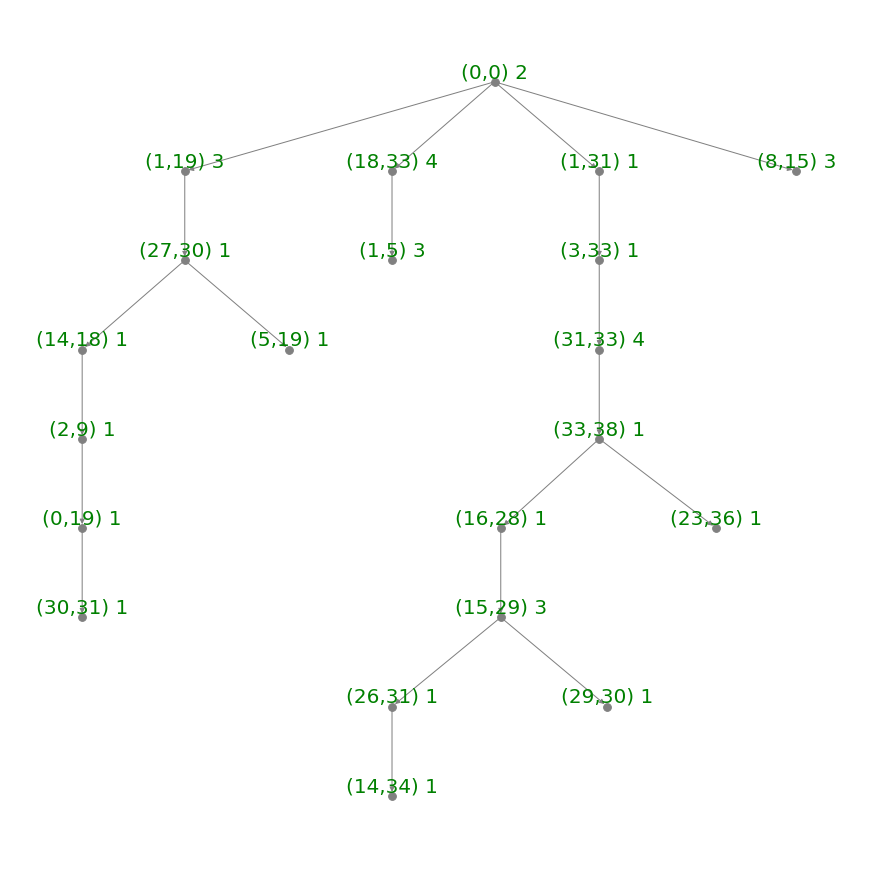

In [80]:
#Plot the ground truth tree
plt.figure(3, figsize=(12,12))
pos = graphviz_layout(tree, prog = "dot")
nx.draw(tree, pos = pos, with_labels=True, node_color = "grey", node_size = 60, verticalalignment = "bottom",
       font_size=20, edge_color="grey", font_color="green")
plt.show()

(array([0.03104657, 0.18923625, 0.63867234, 1.41483663, 1.82879092,
        1.47692977, 0.67563254, 0.21584759, 0.0369602 , 0.00739204,
        0.0177409 , 0.04287384, 0.14340559, 0.23802372, 0.3799509 ,
        0.49230992, 0.53518376, 0.47604743, 0.3252498 , 0.20402033,
        0.09313972, 0.0369602 , 0.01330567, 0.00295682, 0.01034886,
        0.06948518, 0.24098053, 0.42282474, 0.4523929 , 0.29568164,
        0.10201016, 0.02217612, 0.01182727, 0.0177409 , 0.01626249,
        0.02661135, 0.06504996, 0.05913633, 0.07835563, 0.07096359,
        0.08426927, 0.08279086, 0.07392041, 0.04435225, 0.02069771,
        0.02365453, 0.01034886, 0.00295682, 0.        , 0.00591363]),
 array([0.61838079, 0.70293119, 0.78748159, 0.87203198, 0.95658238,
        1.04113278, 1.12568318, 1.21023357, 1.29478397, 1.37933437,
        1.46388477, 1.54843517, 1.63298556, 1.71753596, 1.80208636,
        1.88663676, 1.97118716, 2.05573755, 2.14028795, 2.22483835,
        2.30938875, 2.39393914, 2.47848954, 2.

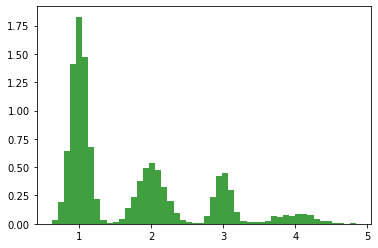

In [81]:
 plt.hist(ccs, 50, density=True, facecolor='g', alpha=0.75)

(array([3.77715893e+00, 3.06584462e+00, 2.12754911e+00, 1.21003356e+00,
        6.58565163e-01, 3.42070254e-01, 1.75830505e-01, 9.91044662e-02,
        9.11121706e-02, 7.51275792e-02, 9.59075480e-02, 8.95137114e-02,
        1.08695221e-01, 9.43090888e-02, 7.19306610e-02, 6.23399062e-02,
        4.79537740e-02, 2.07799687e-02, 1.59845913e-02, 1.43861322e-02,
        4.79537740e-03, 1.43861322e-02, 3.19691827e-02, 3.83630192e-02,
        4.79537740e-02, 5.27491514e-02, 3.19691827e-02, 4.15599375e-02,
        3.03707235e-02, 1.27876731e-02, 7.99229566e-03, 7.99229566e-03,
        1.11892139e-02, 1.11892139e-02, 2.23784279e-02, 1.91815096e-02,
        1.27876731e-02, 2.55753461e-02, 1.11892139e-02, 3.19691827e-02,
        1.59845913e-02, 2.39768870e-02, 1.11892139e-02, 9.59075480e-03,
        1.59845913e-03, 4.79537740e-03, 4.79537740e-03, 0.00000000e+00,
        1.59845913e-03, 1.59845913e-03]),
 array([3.00485830e-06, 7.82033150e-02, 1.56403625e-01, 2.34603935e-01,
        3.12804246e-01

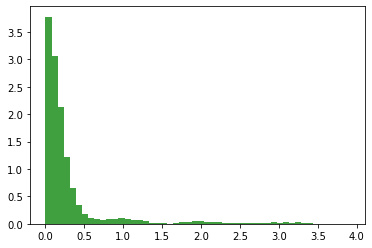

In [82]:
 plt.hist(diffs, 50, density=True, facecolor='g', alpha=0.75)